In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext tensorboard

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 80% !important; }</style>"))

In [4]:
import pong

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydot
import datetime

tf.__version__

'2.0.0'

In [5]:
SEQ_LEN = 128
W, H = 40, 40

stateful_pong_generator = pong.StatefulPongGenerator(W, H, SEQ_LEN, stochasticity=0.85)

def data_input():
    for (d, c), (f, g) in stateful_pong_generator:
        yield (np.array([np.sin(d), np.cos(d)]), c), (f,)

make_dataset = lambda bs: tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), (tf.float32,)),
).take(10_000).cache().repeat().batch(bs).prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
list(make_dataset(10).take(5))[0][0][1].shape

TensorShape([10, 128, 2])

In [29]:
class Model:
    INTERNAL_SIZE = 32

    def project_game_init(self, init_x):
        self.project_state = tf.keras.layers.Dense(
            Model.INTERNAL_SIZE,
            name='project_activation',
            activation='relu'
        )

        return self.project_state(init_x)

    def rollout(self, initial_state, user_input):
        self.gru = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru',
            activation='tanh'
        )
        self.dense = tf.keras.layers.Dense(
            Model.INTERNAL_SIZE,
            name='dense',
            activation='relu',
        )
        self.gru2 = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru3',
            activation='tanh'
        )
        x = self.gru(user_input, initial_state=initial_state)
        x = self.dense(x)
        x = self.gru2(x)

        return x

    def render(self, memory):
        self.renderer = tf.keras.layers.Dense(W * H, activation='sigmoid', name='frame_matrix')
        self.reshaper = tf.keras.layers.Reshape((-1, W, H), name='frame_vector')

        return self.reshaper(self.renderer(memory))

    def __init__(self):
        model_id = 'gru-activation-tanh-2'
        log_dir = 'logs/fit/' + model_id

        self.tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        game_init = tf.keras.layers.Input(shape=(2), name='game_init')
        user_input = tf.keras.layers.Input(shape=(None, 2), name='user_input')

        initial_state = self.project_game_init(game_init)
        rollout_memory = self.rollout(initial_state, user_input)
        frame = self.render(rollout_memory)

        self.net = tf.keras.Model([game_init, user_input], [frame])

        initial_learning_rate = 0.001
        tf.summary.histogram('initial_learning_rate', initial_learning_rate)
        self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=10000,
            decay_rate=0.9,
#             staircase=True
        )
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr_schedule)

        self.net.compile(
            loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['mse']
        )
        
#         self.net.summary(print_fn=lambda x: self.tb_callback.writer.write(x + '\n'))

In [30]:
model = Model()
model.net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
game_init (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
project_activation (Dense)      (None, 32)           96          game_init[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 32)     3456        user_input[0][0]                 
                                                                 project_activation[0][0]   

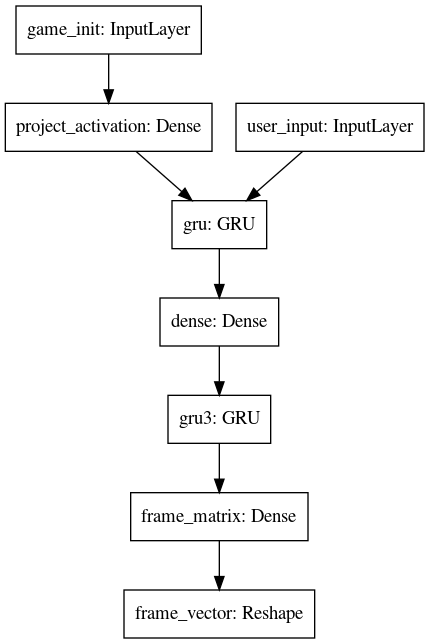

In [31]:
tf.keras.utils.plot_model(model.net, to_file='model.png')

In [32]:
frame_nums = [2, 4, 8, 16, 32, 64, 127]

def plot_pairwise_frames():
    X, Y = list(make_dataset(1).take(1))[0]
    (directions, controls), (frames,) = X, Y
    pred_frames = model.net.predict([directions, controls])

    plot_size = 2
    num_imgs = len(frame_nums)
    fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

    for i, f in enumerate(frame_nums):
        l, r = (axs[0, i], axs[1, i])

        l.imshow(frames[0, f], cmap='bwr')
        r.imshow(pred_frames[0, f], cmap='bwr')

        l.set_xticklabels([])
        r.set_xticklabels([])
        l.set_yticklabels([])
        r.set_yticklabels([])

    fig.tight_layout(pad=0, w_pad=0, h_pad=0)

In [33]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, batch, logs=None):
        plot_pairwise_frames()
        plt.show()

In [34]:
checkpoint_dir = '.checkpoint/'
cp_file_name = 'cp.{epoch:0004d}-{loss:.5f}.hdf5'

In [35]:
!mkdir {checkpoint_dir}
# !ls {checkpoint_dir}

mkdir: cannot create directory ‘.checkpoint/’: File exists


In [36]:
latest = tf.train.latest_checkpoint(checkpoint_dir, latest_filename=cp_file_name)
latest

In [37]:
latest = 'cp.0002-0.05108.hdf5'
checkpoint_dir + latest

'.checkpoint/cp.0002-0.05108.hdf5'

In [38]:
# if latest:
#     model.net.load_weights(checkpoint_dir + latest)

In [39]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir + cp_file_name,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=300,
    mode='min'
)

custom_callback = CustomCallback()

In [40]:
callbacks = [
    custom_callback,
    early_stopping_callback,
    checkpoint_callback,
    model.tb_callback
]

In [41]:
%tensorboard --logdir ./logs

# Time

In [42]:
# %%time
# input_generator = iter(make_dataset(bs=1024))

# for _ in range(21):
#     next(input_generator)

In [43]:
# %%time
# for _ in range(21):
#     next(input_generator)

# Train

In [44]:
input_generator = make_dataset(bs=128)

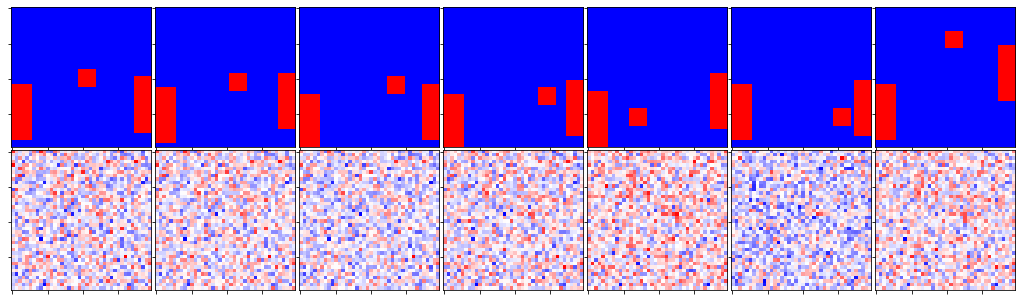

Epoch 1/2500
250/250 [==============================] - 66s 262ms/step - loss: 0.2580 - mse: 0.0753 - val_loss: 0.1813 - val_mse: 0.0500


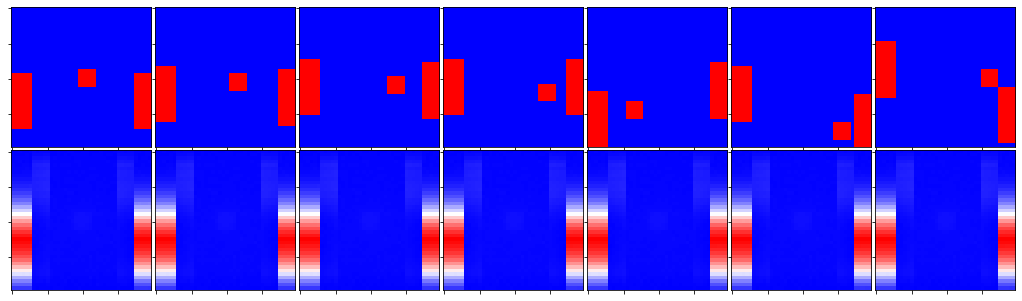

Epoch 2/2500
250/250 [==============================] - 46s 184ms/step - loss: 0.1804 - mse: 0.0500 - val_loss: 0.1804 - val_mse: 0.0500


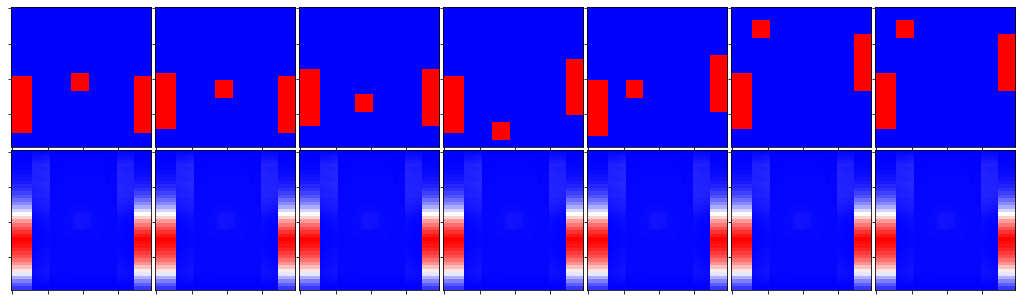

Epoch 3/2500
250/250 [==============================] - 47s 188ms/step - loss: 0.1801 - mse: 0.0500 - val_loss: 0.1803 - val_mse: 0.0500


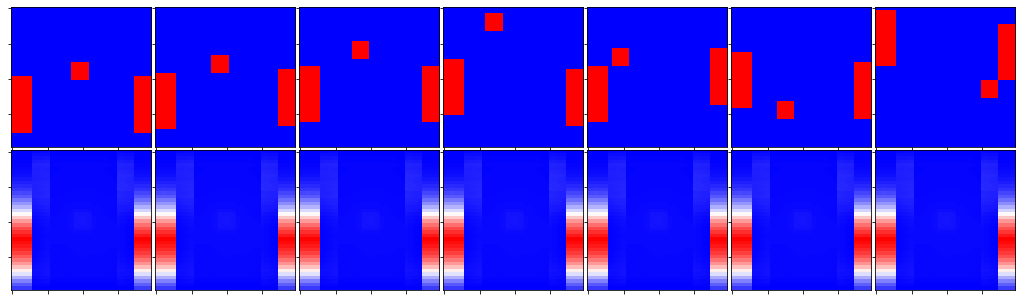

Epoch 4/2500
 41/250 [===>..........................] - ETA: 38s - loss: 0.1796 - mse: 0.0498

In [ ]:
%%time
model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=2,
    steps_per_epoch=250,
    epochs=2500,
    callbacks=callbacks
)

In [28]:
# training_loss = model.net.history.history['loss']
# test_loss = model.net.history.history['val_loss']

# epoch_count = range(1, len(training_loss) + 1)

# plt.plot(epoch_count, training_loss, 'r')
# plt.plot(epoch_count, test_loss, 'b')
# plt.legend(['Validation Loss', 'Test Loss'])
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# model.net.save('04-gru-gru-gru-loss-{}.hdf5')